## Predicting the LIHEAP Funding Formula
### Final Project, Data Science 1 - Foundations
#### PPOL564 Fall 2021
***
**by Alia Abdelkader**
<br> *December 1, 2021*

### Background

The Low Income Home Energy Assistance Program **(LIHEAP)** has been administered by the Department of Health and Human Services (HHS) since 1981 to provide low-income households with financial assistance to cover their energy bills and weatherization of their homes.

LIHEAP is a block grant: the total sum of federal benefits is distributed by using a funding formula that allocates a percentage of the total funds appropriated by Congress to each grantee (U.S. state, territory, or indigenous tribe). States have the autonomy and responsibility to distribute the funds to eligible households that apply for benefits.

### Research Question: Can we predict the LIHEAP Formula?

The LIHEAP Formula was inherited from its predecessor program, the Low Income Energy Assistance Program (LIEAP), which previously favored cold-weather states in terms of funding. The LIEAP formula only used data from specific years, so funding percentages were static.

Congress' 1984 reauthorization of LIHEAP dictated that the LIHEAP Formula should be updated yearly with recent population and energy data. By calling upon the same data sources used by LIHEAP, along with some other variables that could prove influencial, it may be possible to predict the percentage allocation to each state with some accuracy.


- The formula itself is not published, but we know the considerations involved in the process.
- LIEAP was only active for 1 year prior to the adoption of LIHEAP, from 1980-1981
- LIEAP emphasized home heating needs, so colder states received considerably more funding than warmer states
- For the purposes of this analysis, we will exclude territories and tribes because data on these grantees is very limited

### Data Explored

**Known Datasets used to inform LIHEAP Formula**

| Data | Source | Publicly Available? |
| :- | :- | :- |
| Total Residential Energy Consumption and Expenditure Estimates by state | Energy Information Administration (EIA) State Energy Data System (SEDS) | Yes
|Temperature Variation by state - Heating Degree Days (HDD) and Cooling Degree Days (CDD) | National Oceanic and Atmospheric Administration | Yes
| Fuel sources most used by Low-Income Households by state | US Census Bureau's American Community Survey | Yes
| Heating and Cooling Consumption by state | EIA's Residential Energy Consumption Survey (RECS) | No
| Number of income eligible households by state | LIHEAP Data Warehouse | Yes

***

**Other Data of Interest**

| Data | Source | Publicly Available? |
| :- | :- | :- |
| State Detailed Model Plans | LIHEAP Clearinghouse Website | Yes
| Number of severe weather events by state| National Oceanic and Atmospheric Administration | Yes

- There are several datasets that we know LIHEAP uses to inform its funding formula, but there are a few others that I believe could be interesting
- Because a dataset of 51 observations (all states plus Washington DC) is not robust enough for machine learning, I will be including records from 2014-2019, as many datasets aren't yet published beyond 2019.
- One of the datasets that LIHEAP takes into consideration are not publicly available for all years in this frame of analysis:
    - The Residential Energy Consumption Survey takes place every 5 years and only regional estimates are published (data at the state level is not available). As a result, I am leaning towards omitting it from this analysis.

- A state's manual is effectively its application to fund its state LIHEAP program. In it, states answer various questions about how they propose to allocate any funds they receive among different benefits (heating, cooling, weatherization) and also about their state program's application process and eligibility considerations
- NOAA keeps track of the count of severe weather events like storms, floods, droughts, and wildfires, where overall damages/costs reached or exceeded 1 billion dollars. This could be particularly relevant, as many states use a portion of their allocated LIHEAP benefits to fund home weatherization (in fact, LIHEAP spends more on Weatherization than the Department of Energy's Weatherization Assistance Program.

### Data Collection

The available datasets used by LIHEAP are generally available for download as .csv or .txt, while several of them are only available as PDFs.

The State LIHEAP Plans for all state are available as PDFs dating back to 2014. Fortunately, the format of the documents has been consistent. I have used `BeautifulSoup` and `urllib` to write a function that compiles links for all years and downloads the files. As I've only recently located the NOAA webpage on severe weather events, I plan to use a similar approach to download the timeseries data files for each state.

I am using `PyPDF2` to read the files, and am currently working on some text mining to pull information out of those documents. The main challenge has been the interference of page numbers, subheaders, and other random characters within the string of text pulled out of each document.

In [1]:
import os
import PyPDF2
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

# Change working directory to the location where the data file is located
os.chdir('/Users/Alia/Documents/Github/FinalProjectPPOL564/Raw_Data/State_Plans')

pdfFileObj = open('MD_Plan_2019.pdf', 'rb')
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

# -----------------------------------------

# Extract all the text content in the PDF
def read_pdf(file):

    with open(file, 'rb') as pdfFileObj:
        # Open the pdf
        pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

        # Locate the number of pages
        n_pages = pdfReader.numPages

        # Loop through the pages and store the content by
        # appending to a string
        content = ""
        for i in range(n_pages):
            content += pdfReader.getPage(i).extractText()

    return content

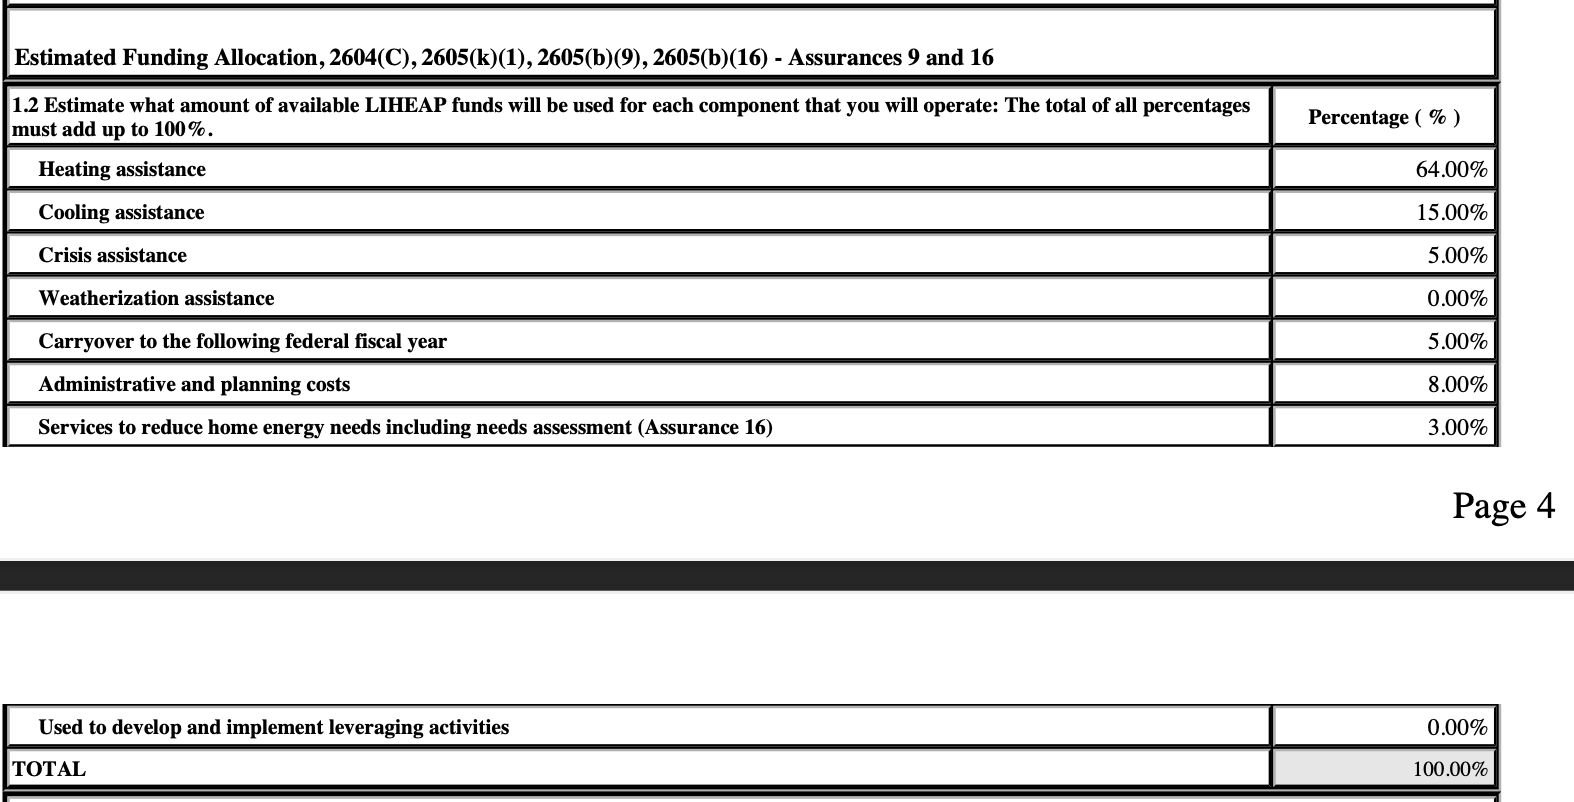

In [2]:
# Examine the PDF page content
content = read_pdf("MD_Plan_2019.pdf")
split1 = content.split("2605(b)(16) - Assurances 9 and 16")[1]
split2 = split1.split("€€€€€",1)[1]
split3 = split2.split("TOTAL",1)[0]
split4 = split3.split("€€€€€")
print(split4)

['Heating assistance64.00%', 'Cooling assistance15.00%', 'Crisis assistance5.00%', 'Weatherization assistance0.00%', 'Carryover to the following federal fiscal year5.00%', 'Administrative and planning costs8.00%', 'Services to reduce home energy needs including needs assessment (Assurance 16)3.00%Page 5', 'Used to develop and implement leveraging activities0.00%']


### Data Wrangling

The bulk of my time thus far has been spent on data wrangling, particularly with energy consumption and expenditure data. There are still a few more columns that I need to add:

- HDD and CDD from NOAA: these need to be read from .txt and summed by year (they are published monthly)
    - LIHEAP uses HDD and CDD in their formula as part of a ratio, which compares the 30-year average of all HHD and CDD nationwide to each state's share of the most recent year's average HDD and CDD respectively
- Most commonly used fuel source by low-income households

In [3]:
os.chdir('/Users/Alia/Documents/Github/FinalProjectPPOL564/Raw_Data')

df = pd.read_csv("Complete_Data.csv")
codes = pd.read_csv("Codes.csv")

In [4]:
df

,Fiscal Year,Grantee,State,Total Program Funding,Income Eligible Fed,Income Eligible State,CLRCB,CLRCV,DFRCB,DFRCV,...,KSRCB,KSRCV,NGRCB,NGRCV,PARCB,PARCV,PQRCB,PQRCV,TERCB,TERCV
0,2014,Alabama,AL,51551796,600043,533182,0,0,101,2.5,...,22,0.6,39842,570.3,5065,156.3,4942,153.3,378853,4544.9
1,2014,Alaska,AK,11172660,61548,48452,0,0,6654,178.9,...,33,1.0,17751,161.6,7075,194.4,388,14.5,47823,764.0
2,2014,Arizona,AZ,22024006,696714,696576,0,0,12,0.3,...,0,0.0,33442,557.2,4097,145.4,4084,145.0,377957,4574.3
3,2014,Arkansas,AR,27575756,343475,337808,0,0,31,0.8,...,16,0.4,38558,396.1,5011,147.6,4964,146.4,246790,2349.2
4,2014,California,CA,152764309,3964208,3961140,0,0,543,15.7,...,334,11.1,408754,4575.1,19681,688.7,18804,661.9,1355028,20075.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,2019,Virginia,VA,100478072,878301,423226,0,0,9431,177.1,...,418,9.5,86516,1032.7,22575,566.8,12726,380.2,571741,7272.1
302,2019,Washington,WA,58044111,722328,349933,0,0,3624,77.8,...,31,0.7,97618,883.5,14550,329.3,10895,250.8,496532,4910.2
303,2019,West Virginia,WV,32408824,237729,199618,0,0,1590,29.9,...,140,3.2,25887,236.1,4622,123.4,2892,90.3,156114,1645.8
304,2019,Wisconsin,WI,111151139,660108,660036,0,0,4879,87.8,...,78,1.8,159117,1164.2,37524,590.5,32568,501.0,447185,4951.9


In [5]:
codes

,MSN Code,Description
0,CLRCB,Coal consumed by the residential sector
1,CLRCV,Coal expenditures in the residential sector
2,DFRCB,Distillate fuel oil consumed by the residentia...
3,DFRCV,Distillate fuel oil expenditures in the reside...
4,ESRCB,"Electricity consumed by (i.e., sold to) the re..."
5,ESRCV,Electricity expenditures in the residential se...
6,HLRCB,Hydrocarbon gas liquids consumed by the reside...
7,HLRCV,Hydrocarbon gas liquids expenditures in the re...
8,KSRCB,Kerosene consumed by the residential sector
9,KSRCV,Kerosene expenditures in the residential sector


In [6]:
df.dtypes

Fiscal Year                int64
Grantee                   object
State                     object
Total Program Funding      int64
Income Eligible Fed        int64
Income Eligible State      int64
CLRCB                      int64
CLRCV                      int64
DFRCB                      int64
DFRCV                    float64
ESRCB                      int64
ESRCV                    float64
HLRCB                      int64
HLRCV                    float64
KSRCB                      int64
KSRCV                    float64
NGRCB                      int64
NGRCV                    float64
PARCB                      int64
PARCV                    float64
PQRCB                      int64
PQRCV                    float64
TERCB                      int64
TERCV                    float64
dtype: object

<AxesSubplot:>

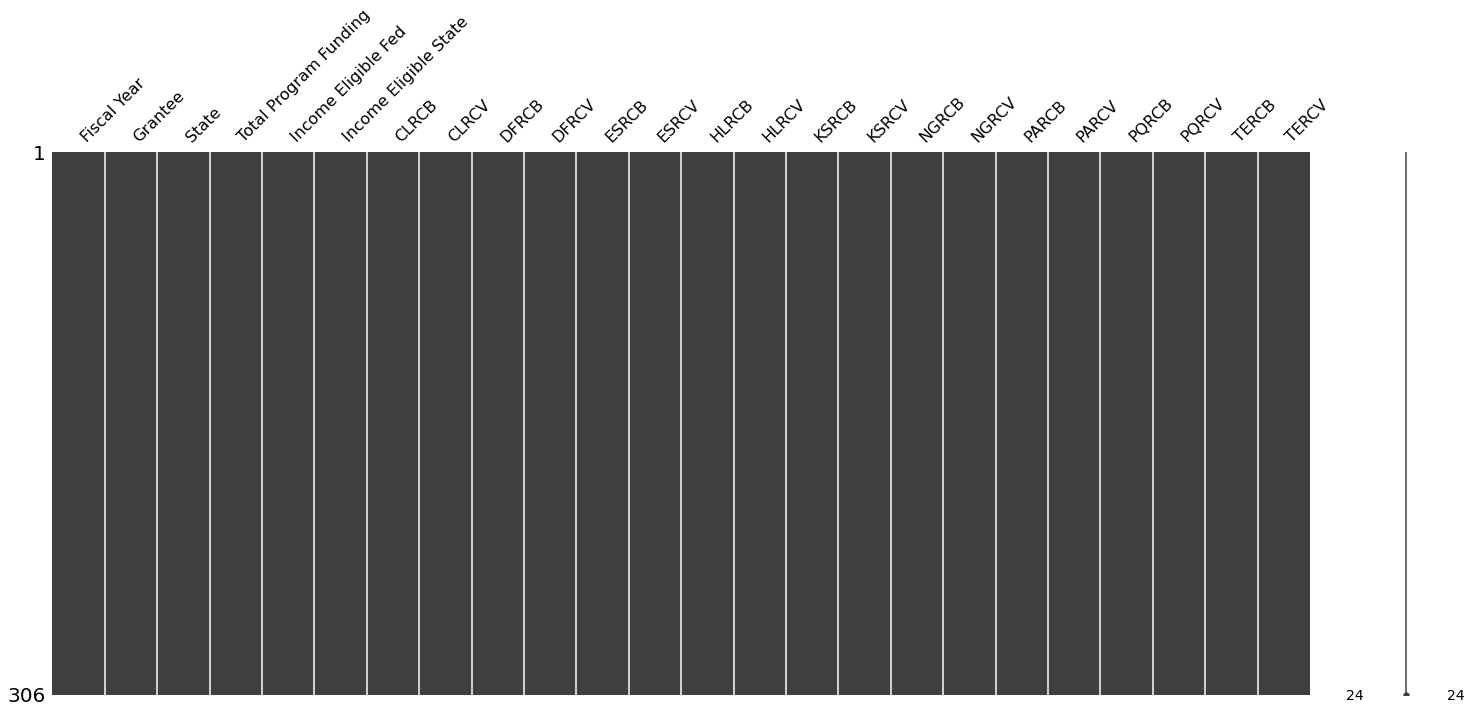

In [7]:
miss.matrix(df)

In [8]:
# Partition data into test and train
y = df[['Total Program Funding']]
X = df.drop(columns=['Total Program Funding'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202112)

print(train_X.shape[0]/df.shape[0])
print(test_X.shape[0]/df.shape[0])

# Create a copy of training data to avoid visualizing test data
d = train_X.select_dtypes(include=["int","float"]).melt()

# Plot the continuous Variables 
plot_continuous = (
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(15,10),
          subplots_adjust={'wspace':.25,'hspace':.3})
)

0.7483660130718954
0.25163398692810457


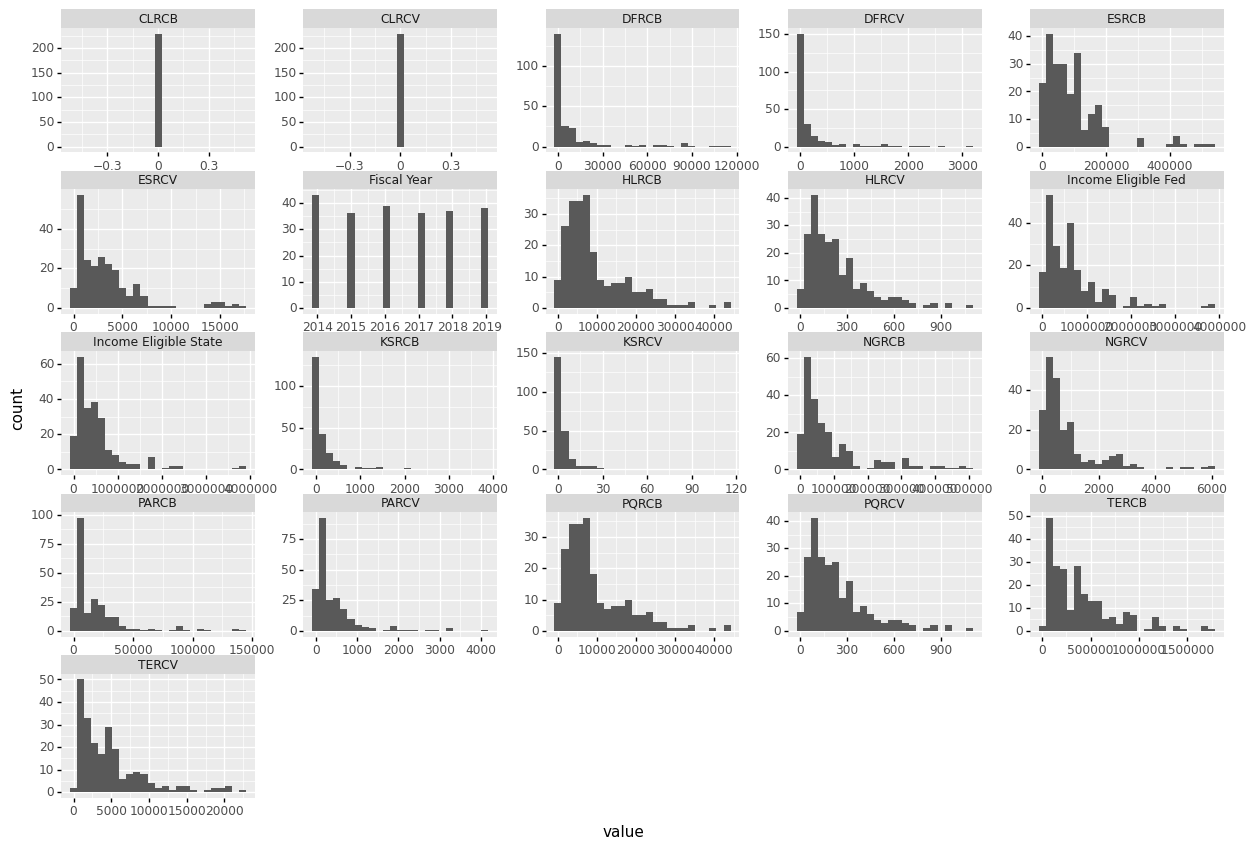

In [9]:
print(plot_continuous)

### Next Steps

- Compile data for additional colums
    - Temperature variation with HDD/CDD ratios
    - Fuel sources most used by low-income households (categorical)
    - Count of extreme weather events
    - *Continue to explore text mining from State Detailed Plans to see I can create a consistent and worthwhile function to pull out insights*
- Work through data preprocessing
- Build Pipeline to run various models through GridSearch
    - Naive Bayes
    - K-Nearest Neighbors
    - Decision Tree
    - Linear Regression
    - Random Forest
- Test model accuracy

### Lessons Learned

1. The data collection and data wrangling process takes a lot longer that I initially anticipated
2. Pulling data from unstructured sources is not for the faint of heart
3. Checking the data sources cited by other published reports/dashboards is a great way to find good raw data
4. Government datasets are not published as often or as comprehensively as one might think
5. All in all, this process has been a fun challenge so far and I'm excited to keep working on it!
